# DAQ（v8）

## 変更箇所

- ``Status``クラス
    - ``show``は現在保持しているメンバー変数を表示するだけにした
    - ``update``関数を``status``にリネームした
- ``UserSettings``クラス
    - ``show``は現在保持しているメンバー変数を表示するだけにした
    - ``setup``は、まず保持した値をrpに設定し、そのあと設定値を確認して、メンバー変数を更新することにした
    - ``setup``関数の内容を分割した
    - メンバー変数に``debug=True``を追加した。本番測定時は表示を減らすことができます。
    - ``fname_prefix``にマイクロ秒（``%f``）を追加しました。1秒以内にトリガーがかかった場合の上書き防止になります。
    - グラフを作成しないと素早くデータ取得できます。といっても1秒以内にトリガーがかかることはないかもしれせんが、ねんのため。
- ``single_event_draw``
    - ch1とch2を同じキャンパスに描画するように変更しました
- ``get_tof``:
    - 波形データの最大値の位置を使って簡易TOFを計算できるようにしました
    - スレッショルド処理済みの波形データを使って、波形がない場合は、計算結果を``float("nan")``としています

# ローカル時刻を確認する

- RedPitayaはRTC（リアルタイムクロック）を持たないので、電源をOFFにした時点で、ローカル時刻が停止します。
- 測定を再開したときは、現在の時刻とローカル時刻がずれてないか確認してください。
- 時刻がずれている場合は、次のセルの時刻を現在時刻に修正して、コメントを外して実行してください
  - 時刻を合わせたあとはまたコメントアウトしてください

In [3]:
#!date -s "2024-03-29 15:04:00+09:00"

In [2]:
!date +%Y-%m-%dT%H:%M:%S

2024-03-29T15:04:00


# 切り取り線

In [4]:
def kiritori():
    """関数の区切りを表示するための遊び関数"""
    print("- - 8< - - " * 12)

# CPU温度を取得する

- https://www.scivision.dev/measure-red-pitaya-cpu-temperature-terminal/ のページを参考にした
- Red PitayaのCPU温度データは ``/sys/bus/iio/devices/iio:device0/`` のディレクトリにあった

In [5]:
def read_tempC(fname: str) -> float:
    """
    CPU温度が記録されたファイルの中身を取得する

    Args:
        fname(str): ファイル名
    Returns:
        line(float): ファイルの1行
    """
    p = Path(fname)
    try:
        return float(p.read_text().strip())
    except Exception as e:
        print(f"Error reading {p}: {e}")
        return None

In [6]:
def get_cpu_tempC() -> float:
    """
    CPU温度を計算する

    ( offset + raw) * scale / 1000.0 で計算できる

    Returns:
        tempC(float): CPU温度
    """
    # CPU温度が保存されているパス
    xadc = Path("/sys/bus/iio/devices/iio:device0")
    off = xadc / "in_temp0_offset"
    raw = xadc / "in_temp0_raw"
    scale = xadc / "in_temp0_scale"

    if all(p.exists() for p in [off, raw, scale]):
        offC = read_tempC(off)
        rawC = read_tempC(raw)
        scaleC = read_tempC(scale)

        if offC is not None and rawC is not None and scaleC is not None:
            # 温度を計算してfloatにキャスト
            tempC = float((rawC + offC) * scaleC / 1000.0)
            return tempC
        else:
            print("Failed to read temperature data.")
            return float("nan")  # 計算できない場合はNaNを返す
    else:
        print("One or more required files do not exist.")
        return float("nan")  # 必要なファイルがない場合もNaNを返す

In [7]:
# get_cpu_tempC()

# モジュールをインポートする

- データ取得に必要なPythonモジュールをインストールします
- Pythonノートブックのセッション開始時に、1回だけ実行してください
  - セッションを再起動（リスタート）したときは、再び実行してください

In [8]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import rp
from dataclasses import dataclass, asdict
from pathlib import Path

print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"RedPitaya: {rp.rp_GetVersion()}")

NumPy: 1.21.5
Pandas: 1.3.5
RedPitaya: 2.00-30 (73ff4bc8f)


# RedPitayaの初期化

- RedPitayaを初期化して測定の準備を開始します
- 関係ありそうなソースファイル
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/python/rp_overlay.py
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/src/rp.c
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/src/acq_handler.c

# DAQの設定値を確認する

- DAQの設定をを確認するためのクラスを作成しました
- 関数の中で``s = Status()``を実行すると、``s``オブジェクトに取得した情報が保存されます
- ``s.show()``で保存された変数を表示できます。
- ひとつの関数の中であれば``s.update()``内容を更新できます

In [10]:
@dataclass
class Status:
    trigger_type: int = -1
    trigger_channel: int = -1
    trigger_level: int = -1
    trigger_delay: int = -1
    decimation: int = -1
    sampling_rate: float = -1.0
    deltaT: float = -1.0
    cpu_tempC: float = -1.0

    def __post_init__(self):
        self.check()
        # self.show()

    def show(self):
        """保持している値を表示する"""
        kiritori()
        header = "[Status.show]"
        print(header)

        print(f"{header} Trigger type: {self.trigger_type}")
        print(f"{header} Trigger channel: {self.trigger_channel}")
        print(f"{header} Trigger level: {self.trigger_level} [V]")
        print(f"{header} Trigger delay: {self.trigger_delay}")
        print(f"{header} Sampling decimation: {self.decimation}")
        print(f"{header} Sampling rate: {self.sampling_rate} [Hz]")
        print(f"{header} Sampling deltaT: {self.deltaT} [sec]")
        print(f"{header} CPU temperature: {self.cpu_tempC} [C]")

    def check(self):
        """現在の設定値を取得する"""

        kiritori()

        header = "[Status.check]"
        print(header)

        if not rp.rp_IsApiInit():
            rp.rp_Init()
            print(f"{header} Initialized API commands (rp.rp_Init)")

        trigger_type = rp.rp_AcqGetTriggerSrc()[1]
        print(f"{header} Trigger type: {trigger_type}")

        channels = {
            rp.RP_TRIG_SRC_CHA_PE: rp.RP_T_CH_1,
            rp.RP_TRIG_SRC_CHB_PE: rp.RP_T_CH_2,
        }
        trigger_channel = channels.get(trigger_type)
        print(f"{header} Trigger channel: {trigger_channel}")

        if trigger_channel is None:
            e = f"{header} ERROR: Wrong trigger source type: {trigger_type}"
            print(e)
            trigger_channel = rp.RP_T_CH_1
            e = f"{header} ERROR: Reset trigger channel: {trigger_channel}"
            print(e)
        print(f"{header} Trigger channel: {trigger_channel}")

        trigger_level = rp.rp_AcqGetTriggerLevel(trigger_channel)[1]
        print(f"{header} Trigger level: {trigger_level}")

        trigger_delay = rp.rp_AcqGetTriggerDelay()[1]
        print(f"{header} Trigger delay: {trigger_delay}")

        decimation = rp.rp_AcqGetDecimation()[1]
        print(f"{header} Sampling decimation: {decimation}")

        rate = rp.rp_AcqGetSamplingRateHz()[1]
        deltaT = 1.0 / rate
        print(f"{header} Sampling rate: {rate}")
        print(f"{header} Sampling interval: {deltaT}")

        tempC = get_cpu_tempC()
        print(f"{header} CPU temperature: {tempC}")

        self.trigger_type = trigger_type
        self.trigger_channel = trigger_channel
        self.trigger_level = trigger_level
        self.trigger_delay = trigger_delay
        self.decimation = decimation
        self.sampling_rate = rate
        self.deltaT = deltaT
        self.cpu_tempC = tempC

In [11]:
# s = Status()

# 測定に必要はパラメーターを設定する

- デシメーション：データのサンプリング率
- トリガーレベル：トリガーの電圧値と信号の向き
- トリガーの遅延：
- バッファーサイズ（サンプリング数）

In [12]:
@dataclass
class UserSettings:
    channels = [rp.RP_CH_1, rp.RP_CH_2]
    trigger_channels = [rp.RP_T_CH_1, rp.RP_T_CH_2]
    trigger_levels = [0.1, 0.1]
    trigger_type: int = rp.RP_TRIG_SRC_CHA_PE
    trigger_delay: int = 0
    decimation: int = rp.RP_DEC_1
    buffers: int = 16384
    version: int = 8
    rp_version: str = rp.rp_GetVersion()
    distance: float = 0.0
    now = datetime.datetime.now()
    debug: bool = True

    def __post_init__(self):
        if self.trigger_type == rp.RP_TRIG_SRC_CHA_PE:
            self.trigger_channel = rp.RP_T_CH_1
        elif self.trigger_type == rp.RP_TRIG_SRC_CHB_PE:
            self.trigger_channel = rp.RP_T_CH_2
        else:
            e = f"Error: Invalid trigger source type: {self.trigger_type}"
            raise ValueError(e)

        self.trigger_level = self.trigger_levels[self.trigger_channel]
        self.sampling_rate = 125e6
        self.deltaT = 1.0 / self.sampling_rate
        self.fname_prefix = f"cw_data_v{self.version}"

    def show(self):
        """保持している値を表示する"""

        kiritori()
        header = "[UseSettings.show]"
        print(header)
        # 現在時刻
        print(f"{header} Timestamp: {self.now}")
        # RF input channels
        for ich in self.channels:
            print(f"{header} RF input: {ich}")
        # Trigger channels
        triggers = zip(self.trigger_channels, self.trigger_levels)
        for ich, iv in triggers:
            print(f"{header} Trigger channel: {ich} | Trigger level: {iv} [V]")

        # Trigger source settings
        print(f"{header} Trigger type: {self.trigger_type}")
        print(f"{header} Trigger channel: {self.trigger_channel}")
        print(f"{header} Trigger level: {self.trigger_level}")
        print(f"{header} Trigger delay: {self.trigger_delay}")

        # Buffer settings
        print(f"{header} Sampling decimation: {self.decimation}")
        print(f"{header} Sampling buffer size: {self.buffers} [samples]")
        print(f"{header} Sampling rate: {self.sampling_rate} [Hz]")
        print(f"{header} Sampling interval: {self.deltaT} [sec]")

        # Versions
        print(f"{header} Distance btw CWs: {self.distance} [mm]")
        print(f"{header} DAQ version: {self.version}")
        print(f"{header} RedPitaya version: {self.rp_version}")
        # Filename
        print(f"{header} Filename prefix: {self.fname_prefix}")

    def update(self):
        """設定を書き込む

        ユーザー設定をRedPitayaに書き込みます。
        初期化したあとに必ず実行する必要があります。

        ```python
        c = UserSettings()
        c.setup()
        ```

        メンバーを更新したあとも必ず実行する必要があります。

        ```python
        c = UserSettings()
        c.trigger_levels = [0.3, 0.3]
        c.setup()
        ```
        """

        kiritori()

        header = "[UserSettings.setup]"
        print(header)

        if self.debug:
            print(f"{header} Show current settings")
            self.show()

        if not rp.rp_IsApiInit():
            rp.rp_Init()
            print(f"{header} Initialized API commands (rp.rp_Init)")

        print(f"{header} Reset DAQ (rp.rp_AcqReset)")
        rp.rp_AcqReset()
        self.setup()
        self.update_time()

        if self.debug:
            print(f"{header} Show updated settings")
            self.show()

    def setup(self):
        self.setup_trigger_levels()
        self.setup_trigger_delay()
        self.setup_decimation()
        self.setup_trigger_source()

    def setup_trigger_levels(self):
        """チャンネルごとのトリガーレベルを設定する"""
        header = "[UserSettings.setup_trigger_levels]"
        print(header)

        # 現在のメンバー変数を取得する
        present_channels = self.trigger_channels
        present_levels = self.trigger_levels

        # チャンネルごとに値を設定する
        updated_channels = []
        updated_levels = []
        for ich, iv in zip(present_channels, present_levels):
            # 設定する
            print(f"{header} Set trigger channel: {ich} | trigger level: {iv} [V]")
            rp.rp_AcqSetTriggerLevel(ich, iv)
            time.sleep(0.1)
            # 取得する
            level = rp.rp_AcqGetTriggerLevel(ich)[1]
            time.sleep(0.1)
            updated_channels.append(ich)
            updated_levels.append(level)

        # メンバー変数を更新する
        self.trigger_channels = updated_channels
        self.trigger_levels = updated_levels

    def setup_trigger_delay(self):
        """トリガー遅延を設定する

        データ記録を開始する点（トリガー点）をサンプル数で設定する。
        トリガー点は：
        - 0の場合: バッファーサイズの中心になる。
        - 正の値: 早くなる（左に移動する）
        - 負の値: 遅くなる（右に移動する）
        """
        header = "[UserSettings.setup_trigger_delay]"
        print(header)

        # 現在のメンバー変数を取得する
        present_delay = self.trigger_delay

        # 設定する
        print(f"{header} Set trigger delay: {present_delay} [samples]")
        rp.rp_AcqSetTriggerDelay(present_delay)
        time.sleep(0.1)

        # 取得する
        updated_delay = rp.rp_AcqGetTriggerDelay()[1]

        # メンバー変数を更新する
        self.trigger_delay = updated_delay

    def setup_decimation(self):
        """デシメーションを設定する

        サンプリング数を（間引く割合）を設定する。
        デシメーションを設定すると、より広い時間レンジで測定できるようになる
        デシメーションの値は2の倍数で設定する。
        1: 全サンプリング点が有効
        2: サンプリング数を半減する
        4: ...
        """
        header = "[UserSettings.setup_decimation]"
        print(header)

        # 現在のメンバー変数を取得する
        present_decimation = self.decimation
        present_rate = self.sampling_rate
        present_deltaT = self.deltaT

        # 設定する
        print(f"{header} Set sampling decimation: {present_decimation} [samples]")
        rp.rp_AcqSetDecimation(present_decimation)
        time.sleep(0.1)

        # 取得する
        updated_decimation = rp.rp_AcqGetDecimation()[1]
        updated_rate = rp.rp_AcqGetSamplingRateHz()[1]
        updated_deltaT = 1.0 / updated_rate

        # メンバー変数を更新する
        self.trigger_decimation = updated_decimation
        self.sampling_rate = updated_rate
        self.deltaT = updated_deltaT

    def setup_trigger_source(self):
        """トリガーソースを設定する

        トリガーソースはDAQを開始したあとで設定する
        設定値は
        - トリガーに設定するチャンネル番号
        - トリガー信号の条件
        で決められた値にする

        rp.RP_TRIG_SRC_CHA_PE : Ch1 && PositiveEdge = 2
        rp.RP_TRIG_SRC_CHB_PE : Ch1 && PositiveEdge = 4
        """
        header = "[UserSettings.setup_trigger_source]"
        print(header)

        print(f"{header} Start DAQ (rp.rp_AcqStart)")
        rp.rp_AcqStart()
        time.sleep(1)

        # 現在のメンバー変数を取得する
        present_type = self.trigger_type
        present_channel = self.trigger_channel
        present_level = self.trigger_level

        # 設定する
        print(f"{header} Set trigger type: {present_type}")
        rp.rp_AcqSetTriggerSrc(present_type)
        time.sleep(1)

        # 取得する
        # FIXME: この rp_AcqGetTriggerSrc はよく失敗するため信用していない
        # 失敗すると0が返ってくるため
        # もともとの設定値と異なる場合は、エラーメッセージを表示して、
        # もともとの値に戻している
        updated_type = rp.rp_AcqGetTriggerSrc()[1]
        if updated_type != present_type:
            e = f"ERROR: Wrong trigger source type: {updated_type}"
            print(f"{header} {e}")
            updated_type = present_type
        updated_channel = present_channel
        updated_level = rp.rp_AcqGetTriggerLevel(updated_channel)[1]

        # メンバー変数を更新する
        self.trigger_type = updated_type
        self.trigger_channel = updated_channel
        self.trigger_level = updated_level

    def update_time(self):
        """現在時刻を更新する

        現在時刻を更新する。
        時刻の更新に伴い、ファイル名も更新する

        例:
            cw_data_v8_ch1_100mV.csv
            c2_data_v8_ch2_100mV.csv
        """
        kiritori()
        header = "[UserSettings.update_time]"
        print(header)

        # 現在時刻を取得する
        now = datetime.datetime.now()

        # ファイル名の作成にとりかかる
        channel_name = f"ch{self.trigger_channel + 1}"
        # channel_name = f"src{self.trigger_type}"
        trigger_mv = f"{int(self.trigger_level * 1000)}mV"
        prefix = f"cw_data_v{self.version}"
        prefix = f"{prefix}_{channel_name}_{trigger_mv}"
        dt = now.strftime("%Y%m%d_%H%M%S_%f")
        prefix = f"{prefix}_{dt}"
        print(f"{header} Filename prefix: {prefix}")
        self.fname_prefix = prefix

        return now

In [13]:
# s = Status()
# s.show()

kiritori()

# c = UserSettings()
# c.update()
# c.show()

# kiritori()

# s = Status()
# s.show()

- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 


In [14]:
# c = UserSettings()
# c.show()

## トリガーチャンネル
# c.trigger_channels = [rp.RP_T_CH_1, rp.RP_T_CH_2]

## トリガーレベル
# c.trigger_levels = [0.40, 0.20]

## トリガーソース
## CHA|CHB : Ch1|Ch2に該当する
## PE : PositiveEdge（立ち上がり）でトリガー
# c.trigger_source = rp.RP_TRIG_SRC_CHA_PE  # 2
# c.trigger_source = rp.RP_TRIG_SRC_CHB_PE  # 4

## トリガー遅延（サンプル点の数）
## 正の数：トリガー点が左に移動する
## 負の数：トリガー点が右に移動する
# c.trigger_delay = 7500

## デシメーション
## サンプリング数を間引く度合い: 2の倍数で指定できる
# c.decimation = rp.RP_DEC_2
# c.decimation = rp.RP_DEC_8

## バッファーサイズ（サンプリング数）
## 最大値：16384
# c.samples = 1500

# 変更した値を設定する
# c.setup()
# c.show()

In [15]:
# c.update()
# c.show()
# c.update()
# c.show()
# c.update()
# c.show()

# DAQをセットアップする

- スレッショルドをを途中で変更する例

In [16]:
# c = UserSettings()
# c.trigger_levels = [0.8, 0.8]
# c.setup()
# s = Status()

# トリガーがかかるまで待つ

In [17]:
def single_event_trigger() -> int:
    """1イベントのトリガーを待つ"""
    kiritori()
    header = "[single_event_trigger]"
    print(header)

    # トリガーを待つ
    print(f"{header} Waiting for a trigger...")
    print(f"{header}     Trigger state: {rp.rp_AcqGetTriggerState()}")
    print(f"{header}     Fill state: {rp.rp_AcqGetBufferFillState()}")
    counter = 0

    while 1:
        trigger_state = rp.rp_AcqGetTriggerState()[1]
        counter = counter + 1
        if counter % 1000000 == 0:
            print(f"{header} Loop: {counter}")
        if trigger_state == rp.RP_TRIG_STATE_TRIGGERED:
            break

    print(f"{header} Triggered!")
    print(f"{header}     Trigger state: {rp.rp_AcqGetTriggerState()}")
    print(f"{header}     Fill state: {rp.rp_AcqGetBufferFillState()}")

    # データがあるか確認する
    while 1:
        if rp.rp_AcqGetBufferFillState()[1]:
            break

    print(f"{header} Got Data")
    return counter

In [18]:
# c = UserSettings()
# single_event_trigger()

# 波形データを読み出す

In [19]:
def single_event_readout(config: UserSettings) -> pd.DataFrame:
    """波形データをデータフレームに変換する

    # チャンネル番号に応じた内部バッファー（osc_cha, osc_chb, osc_chc, osc_chd）
    # チャンネル番号に応じたバッファーを読み出せる（osc_GetDataBufferChA(), ...）
    # チャンネル番号を指定してバッファーを読み出す（getRawBuffer(チャンネル))
    # ADC値を読み出す（rp_AcqGetOldestDataRaw(チャンネル番号, サイズ, バッファー)）
    # 電圧に変換した値を読み出す（rp_AcqGetOldestDataV(チャンネル番号, サイズ, バッファー)）
    """

    kiritori()
    header = "[single_event_readout]"
    print(header)

    # データ処理の開始時刻を取得したいため、内部変数を更新する
    config.update_time()
    _buffers = config.buffers
    _channels = config.channels
    _version = config.version
    _deltaT = config.deltaT

    # 波形データをデータフレームに変換する
    print(f"{header} Convert waveforms into pd.DataFrame")
    waveforms = {}

    for ich in _channels:
        print(f"{header} Readout Ch{ich}")
        # RAW（ADC値）
        ibuff = rp.i16Buffer(_buffers)
        res = rp.rp_AcqGetOldestDataRaw(ich, _buffers, ibuff.cast())[1]

        # Volts（ADC値を電圧（V）に変換した値）
        fbuff = rp.fBuffer(_buffers)
        res = rp.rp_AcqGetOldestDataV(ich, _buffers, fbuff)[1]

        # データを保存する配列を作成する
        data_raw = np.zeros(_buffers, dtype=int)
        data_volts = np.zeros(_buffers, dtype=float)

        # データをコピーする
        for i in range(0, _buffers, 1):
            data_raw[i] = ibuff[i]
            data_volts[i] = fbuff[i]

        # データを代入する
        key1 = f"raw{ich+1}"
        key2 = f"v{ich+1}"
        waveforms[key1] = data_raw
        waveforms[key2] = data_volts

    print(f"{header} Add columns to pd.DataFrame")
    data = pd.DataFrame(waveforms)
    data["x"] = data.index
    data["time"] = data.index * _deltaT
    data["deltaT"] = data["time"].diff()
    data["totalT"] = data["deltaT"].cumsum()

    return data

In [20]:
# c = UserSettings()
# single_event_trigger()
# data = single_event_readout(c)
# data

# カスタマイズ

- 波形データごとのオフセットを補正する
- オフセットの平均値と標準偏差を使ってスレッショルドを計算する
- 各点の電荷を計算する
- TOFを計算する
- 測定時のCPU温度を取得する

# スレッショルドを再計算する

- データの先頭から"100:200"あたりを使ってベースラインを計算する
- ベースラインの平均値と標準偏差を使って、信号の閾値を計算する

In [21]:
def get_threshold(
    data: pd.DataFrame, name: str, width: float = 3.0
) -> tuple[float, float, float]:
    """信号の閾値を計算する
    Args:
        data(pd.DataFrame): 波形データ
        name(str): 計算したいカラム名
        width(float): 閾値の幅
    Returns:
        threshold(float)
    """
    header = "[get_threshold]"
    print(header)
    copied = data.copy()
    mean = copied[name].mean()
    std = copied[name].std()
    threshold = mean + width * std
    print(f"{header} m: {mean} | s: {std} | t: {threshold}")
    return mean, std, threshold

In [22]:
# c = UserSettings()
# single_event_trigger()
# data = single_event_readout(c)
# print(get_threshold(data.iloc[100:200], name="v1"))
# print(get_threshold(data.iloc[100:200], name="v2"))

In [23]:
def discriminator(data: pd.DataFrame, name: str, start: int = 100, end: int = 200):
    kiritori()
    header = "[discriminator]"
    print(header)
    copied = data.copy()

    # オフセット補正
    mean, std, threshold = get_threshold(copied.iloc[start:end], name)
    copied["fixed"] = copied[name] - mean

    # スレショルド補正
    copied["valid"] = 0.0
    isT = copied["fixed"] > threshold
    copied.loc[isT, "valid"] = copied["fixed"]

    # スレッショルドを越えたサンプル数と割合
    N = len(copied)
    T = isT.sum()
    ratio = T / N
    print(f"{header} {name} N: {N} >>> {T} | Selected: {ratio * 100:.2f} %")

    return copied["fixed"], copied["valid"]

In [24]:
# c = UserSettings()
# single_event_trigger()
# data = single_event_readout(c)
# data["v1_fixed"], data["v1_valid"] = discriminator(data, name="v1")
# data["v2_fixed"], data["v2_valid"] = discriminator(data, name="v2")
# data

In [25]:
def get_deltaQ(
    data: pd.DataFrame,
    name: str,
    unitV: float = 1.0,
    unitT: float = 1e-6,
    ohmR: float = 50.0,
):
    """サンプルあたりの電荷を計算する
    Args:
        data(pd.DataFrame): 波形データ（スレッショルド適応済み）
        name(str): 計算に使うカラム名（[v1_valid|v2_valid]）
        unitV(float): 測定した電圧の単位（デフォルトは V）
        unitT(float): 測定した時間の単位（デフォルトは 1e-6 s）
        ohmR(float): 測定したときの抵抗値（デフォルトは 50.0 Ohm）
    """
    copied = data.copy()
    unitQ = unitV * unitT / ohmR
    deltaQ = copied[name] * data["deltaT"] * unitQ
    return deltaQ

In [26]:
def add_deltaQ(data: pd.DataFrame):
    """電荷を計算したカラムを追加する"""
    copied = data.copy()

    # Ch1の計算
    copied["v1_fixed"], copied["v1_valid"] = discriminator(data, name="v1")
    copied["q1"] = get_deltaQ(copied, name="v1_valid")

    # Ch2の計算
    copied["v2_fixed"], copied["v2_valid"] = discriminator(data, name="v2")
    copied["q2"] = get_deltaQ(copied, name="v2_valid")

    return copied

# TOFを計算する

- ベースラインとスレッショルド補正した波形データを使う（``v1_valid`` | ``v2_valid``）
- この2つのデータを使って相関関数を計算する

In [27]:
def get_tof(data: pd.DataFrame) -> int:
    """波高を使ってTOFを計算する

    波高が最大となるインデックスを取得して、その差をTOFと定義します。
    ch1とch2のどちらのデータが先になるかは自明ではないはずなので、
    とりあえず符号をつけたまま計算しておきます。
    必要であれば、解析時に絶対値に変換することができます。

    また、波高の最大値も確認しておきます。
    データがスレッショルド未満であれば、この値は0になります。
    データが存在しないため、TOFを計算できません。
    よって、このときは None を返すことにします

    Args:
        data(pd.DataFrame): 波形データ（補正済み）
    Returns:
        tof(float): 計算したTOFの値
    """
    copied = data.copy()

    x1 = copied["v1_valid"].idxmax()
    x2 = copied["v2_valid"].idxmax()
    xdiff = x1 - x2

    # 波高の最大値を取得する
    # データが閾値を超えない場合、この値は0になる
    v1 = copied["v1_valid"].max()
    v2 = copied["v2_valid"].max()
    if v1 == 0 or v2 == 0:
        xdiff = None

    return xdiff

# イベントサマリーを確認する

In [28]:
def single_event_summary(config: UserSettings, data: pd.DataFrame):
    """波形データの最大値を確認する
    Args:
        config(UserSettings): ユーザー設定
        data(pd.DataFrame): 波形データ（補正済み）
    Returns:
        summary(dict): イベントごとのサマリを計算した辞書型オブジェクト
    """

    kiritori()
    header = "[single_event_summary]"
    print(header)

    # 電荷を計算する
    q1 = data["q1"].sum()
    q2 = data["q2"].sum()

    # 波高の最大値を取得する
    v1 = data["v1_valid"].max()
    v2 = data["v2_valid"].max()

    # 波高が最大値のインデックス（=X軸）を取得する
    x1 = data["v1_valid"].idxmax()
    x2 = data["v2_valid"].idxmax()

    # TOFを計算する
    xdiff = get_tof(data)
    if xdiff is None:
        tof = float("nan")
    else:
        tof = float(xdiff) * config.deltaT

    # CPU温度を取得する
    cpu_tempC = get_cpu_tempC()

    # データフレームを表示する
    # display(data[x1-10:x1+10])
    print(f"{header} ch1 (x1, v1, q1) = ({x1}, {v1}, {q1})")
    print(f"{header} ch2 (x2, v2, q1) = ({x2}, {v2}, {q2})")

    summary = {
        "x1": x1,
        "v1": v1,
        "q1": q1,
        "x2": x2,
        "v2": v2,
        "q2": q2,
        "tof": tof,
        "cpu_tempC": cpu_tempC,
    }
    return summary

In [29]:
# c = UserSettings()
# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# single_event_summary(c, data)

# 波形をグラフにする

In [30]:
def single_event_draw(config: UserSettings, data: pd.DataFrame):
    """波形データを描画する

    信号がありそうな領域にフォーカスしたグラフを作成する。
    そのため、波高が最大値をとる点（インデックス）を探し、その周辺にスライスする。
    """
    kiritori()
    header = "[single_event_draw]"
    print(header)

    copied = data.copy()

    # ファイル名を取得する
    # ファイル名はグラフのタイトルにも使う
    prefix = config.fname_prefix

    # 波高が最大となるインデックスを取得する
    print(f"{header} Get index (X) at the maximum wave height")
    x1 = data["v1_valid"].idxmax()
    x2 = data["v2_valid"].idxmax()

    # その周辺のデータを抽出する
    width = 200
    if x2 == 0:
        xmin = x1
        xmax = x1
    else:
        xmin = min(x1, x2)
        xmax = max(x1, x2)

    data1 = copied[xmin - width : xmax + width]

    # データをプロットする
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout="constrained")
    fig.suptitle(prefix)
    axs = axs.ravel()

    data1.plot.scatter(x="x", y="raw1", ax=axs[0], label="ch1")
    data1.plot.scatter(x="x", y="raw2", ax=axs[0], label="ch2", c="red")

    data1.plot.scatter(x="time", y="v1", ax=axs[1], label="ch1")
    data1.plot.scatter(x="time", y="v2", ax=axs[1], label="ch2", c="red")

    data1.plot.scatter(x="time", y="q1", ax=axs[2], label="ch1")
    data1.plot.scatter(x="time", y="q2", ax=axs[2], label="ch2", c="red")

    print(f"{header} {config.fname_prefix}")
    fname = f"data/{prefix}.png"
    fig.savefig(fname)
    print(f"{header} Saved to {fname}")

    return fig, fname

In [31]:
# c = UserSettings()
# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# summary = single_event_summary(c, data)
# fig, fname = single_event_draw(c, data)

# データを保存する

In [32]:
def single_event_save(config: UserSettings, data: pd.DataFrame):
    """データフレームを保存する
    Args:
        config(UserSettings): ユーザー設定
        data(pd.DataFrame): 波形データ（いろいろ計算済み）
    Returns:
        saved(dict): 保存したデータのサマリー
    """

    kiritori()
    header = "[single_event_save]"
    print(f"{header} Save data")
    version = config.version
    now = config.now

    data["timestamp"] = now
    data["version"] = version

    fname = f"data/{config.fname_prefix}.csv"
    data.to_csv(fname, index=False)
    print(f"{header} Saved to {fname}")

    saved = {
        "timestamp": now,
        "version": version,
        "rp_version": config.rp_version,
        "csv": fname,
    }

    return saved

In [33]:
# c = UserSettings()
# c.trigger_levels = [0.2, 0.2]
# c.setup()

# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# summary = single_event_summary(c, data)
# fig, png = single_event_draw(c, data)
# saved = single_event_save(c, data)
# saved

In [34]:
def single_event(config: UserSettings, draw: bool):
    """1イベントを取得する
    Args:
        config(UserSettings): ユーザー設定
    Returns:
        saved(dict): イベントサマリー
    """
    kiritori()
    header = "[single_event]"
    print(header)

    # DAQ設定を更新する
    # イベントごとにDAQ設定を更新できるようにした
    config.update()

    # DAQを実行する
    count = single_event_trigger()
    data = single_event_readout(c)

    # 電荷を計算する
    data = add_deltaQ(data)

    # イベントのサマリーを計算する
    # [x] 波高が最大となるインデックス
    # [x] 波高の最大値
    # [x] 電荷の計算
    # [ ] TOF
    # [x] CPU温度
    summary = single_event_summary(c, data)

    # 波形データを保存する
    saved = single_event_save(config, data)

    # 波形データをグラフに保存する
    if draw:
        fig, png = single_event_draw(c, data)
        saved["png"] = png
    else:
        print(f"{header} Skipped draw...")

    # イベントのサマリーを作成する
    summary["count"] = count
    saved.update(summary)

    # DAQの状態を確認して追加する
    status = Status()
    status.show()
    d = asdict(status)
    saved.update(d)
    time.sleep(1)

    return saved

In [35]:
# c = UserSettings()
# c.trigger_levels = [0.2, 0.2]
# c.trigger_source = rp.RP_TRIG_SRC_CHB_PE  # 4
# status = single_event(c, draw=True)
# status

In [36]:
def loop_events(config: UserSettings, draw: bool, nloop: int = 10):
    """データ取得を繰り返す"""
    kiritori()
    header = "[loop_events]"
    print(header)

    c.update()

    summary = []
    for i in range(nloop):
        try:
            kiritori()
            print("〓" * 80)
            print(f"{header} Event Loop: {i+1}/{nloop}")
            print("〓" * 80)
            status = single_event(c, draw)
            status["run_id"] = i + 1
            summary.append(status)
        except KeyboardInterrupt as e:
            print(type(e), e)
            data = pd.DataFrame(summary)
            return data

    kiritori()
    c.update_time()
    print(f"{header} Save summary as pd.DataFrame")
    data = pd.DataFrame(summary)
    prefix = config.fname_prefix
    fname = f"data/summary_{prefix}.csv"
    data.to_csv(fname, index=False)
    print(f"{header} Saved to {fname}")
    print(f"{header} Finished!")

    return data

- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[loop_events]
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[UserSettings.setup]
[UserSettings.setup] Show current settings
- - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - - - 8< - - 
[UseSettings.show]
[UseSettings.show] Timestamp: 2024-03-29 15:04:40.796393
[UseSettings.show] RF input: 0
[UseSettings.show] RF input: 1
[UseSettings.show] Trigger channel: 0 | Trigger level: 0.1 [V]
[UseSettings.show] Trigger channel: 1 | Trigger level: 0.1 [V]
[UseSettings.show] Trigger type: 2
[UseSettings.show] Trigger channel: 0
[UseSettings.show] Trigger level: 0.1
[UseSettings.show] Trigger delay: 0
[UseSettings.show] Sampling decimation: 1
[UseSettings.show] Sampling buffer size: 16384 [samples]
[UseSettings.

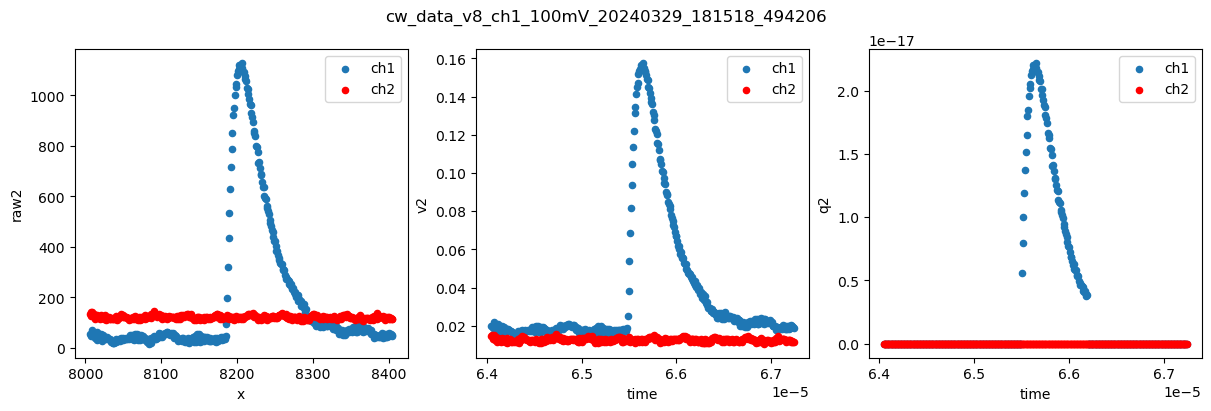

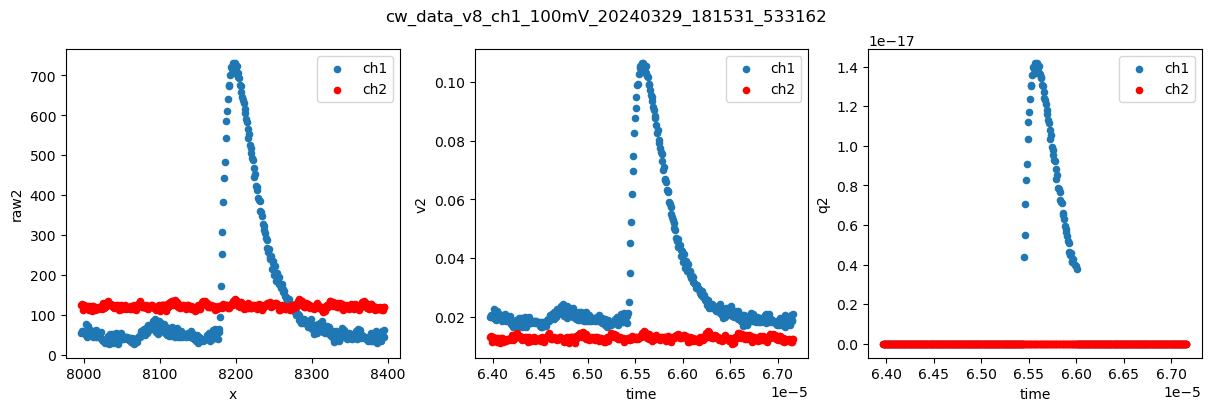

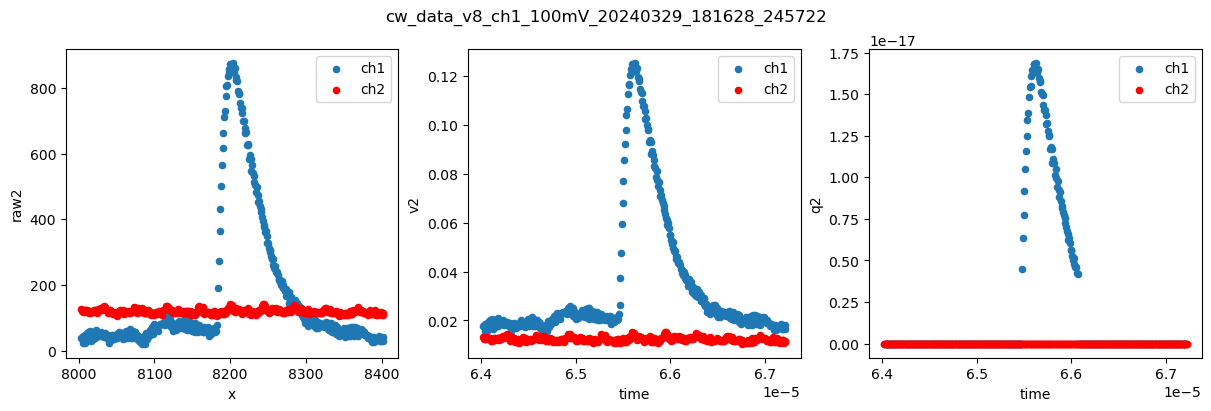

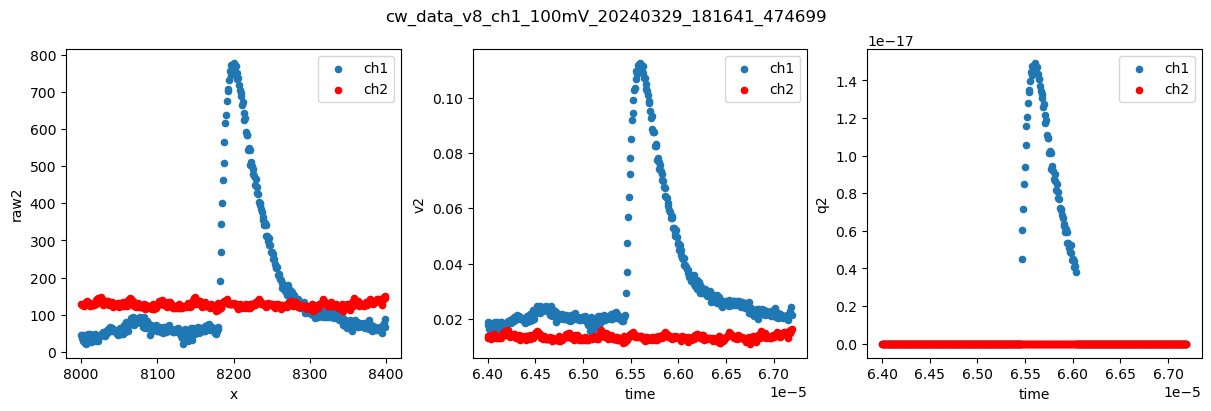

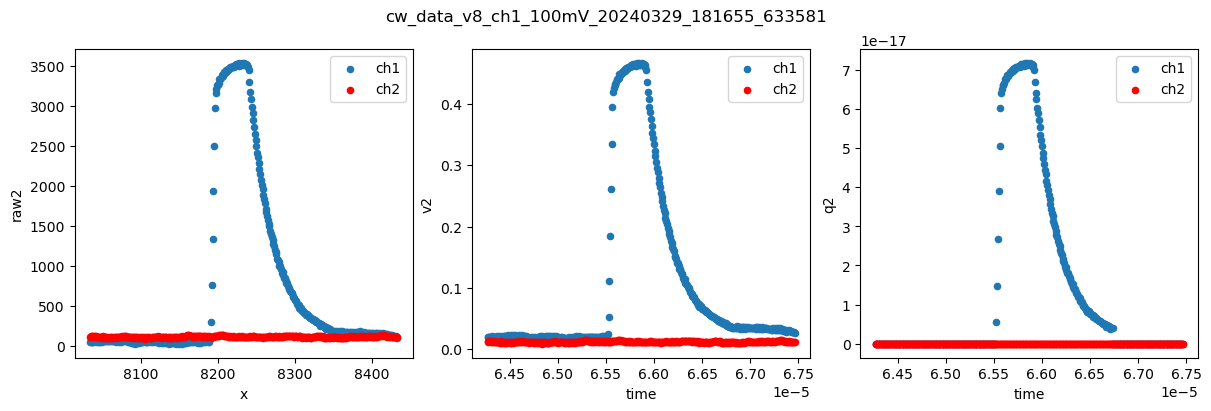

In [79]:
c = UserSettings()
c.trigger_levels = [0.1, 0.1]
# c.trigger_source = rp.RP_TRIG_SRC_CHA_PE
events = loop_events(c, draw=True, nloop=10)

# 10ループを繰り返す

一晩中測定してみようと思いますが、RedPitayaの調子が途中で悪くなることが考えられます。
``loop_events``ではループがすべて終わったときに、サマリーがファイルに保存されます。
途中で中断すると、すべてのサマリーが消えることになるため、小さいループをたくさん回すことにします。

測定したイベントの波形は残るので、再解析すればサマリーは取得できます。
同様の理由でグラフも作成できるため、今回はプロットは作らずに回しています。

In [28]:
# c = UserSettings(debug=False)
# events = loop_events(c, draw=False, nloop=10)

In [ ]:
# c = UserSettings(debug=False)
# levels = 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# n = len(levels)

# for i, level in enumerate(levels):
#    print("⭐️" * 40)
#    print(f"Run Loop {level} V | {i+1} / {n}")
#    c.trigger_levels = [level, level]
#    events = loop_events(c, draw=False, nloop=100)


# print("Finished! 👍👍👍")

<AxesSubplot:xlabel='run_id', ylabel='cpu_tempC'>

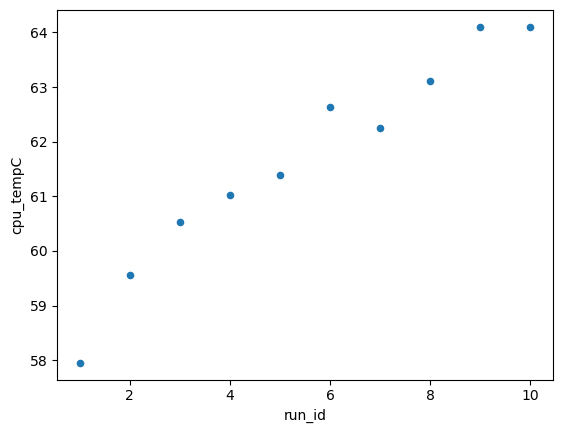

In [38]:
events.plot.scatter(x="run_id", y="cpu_tempC")

In [39]:
# TOFが計算できたイベント数の割合
events["tof"].notnull().sum() / len(events)

0.1

In [40]:
isT = events["tof"].notnull()
valid = events[isT]

<AxesSubplot:xlabel='tof', ylabel='q1'>

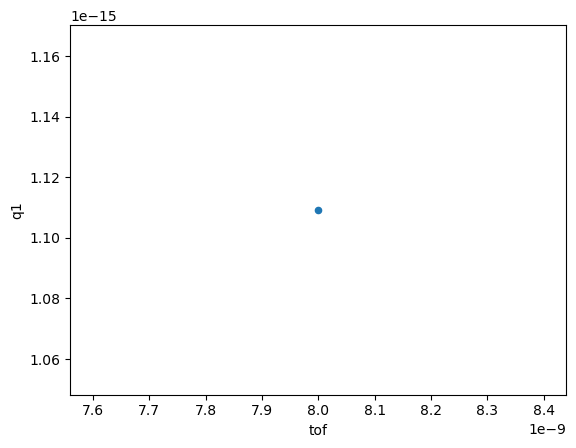

In [41]:
valid.plot.scatter(x="tof", y="q1")

In [42]:
valid.plot.scatter(x="tof", y="q2")

<AxesSubplot:xlabel='tof', ylabel='q2'>

In [43]:
valid.columns

Index(['timestamp', 'version', 'rp_version', 'csv', 'png', 'x1', 'v1', 'q1',
       'x2', 'v2', 'q2', 'tof', 'cpu_tempC', 'count', 'trigger_type',
       'trigger_channel', 'trigger_level', 'trigger_delay', 'decimation',
       'sampling_rate', 'deltaT', 'run_id'],
      dtype='object')

In [44]:
valid.plot.scatter(x="x1", y="x2")

<AxesSubplot:xlabel='x1', ylabel='x2'>

<AxesSubplot:xlabel='q1', ylabel='q2'>

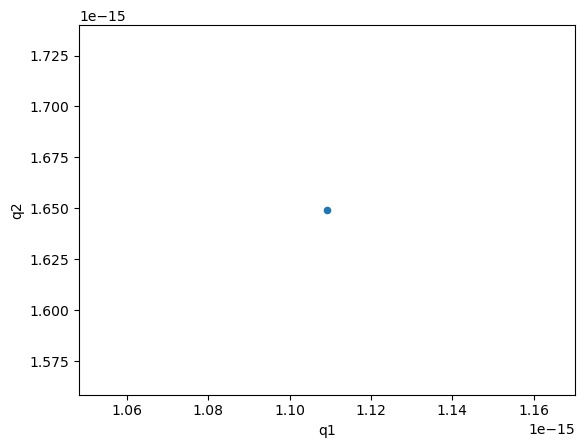

In [45]:
valid.plot.scatter(x="q1", y="q2")